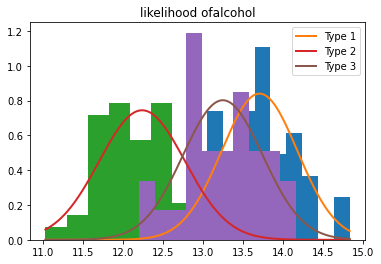

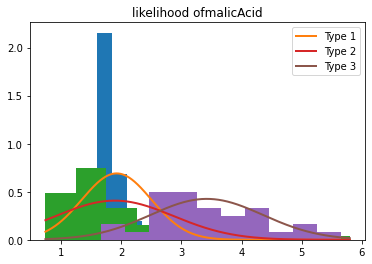

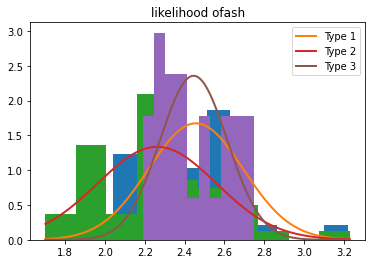

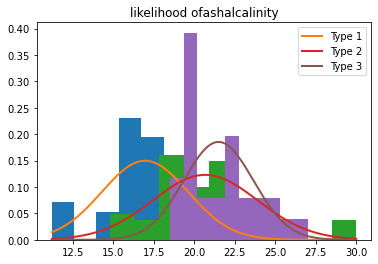

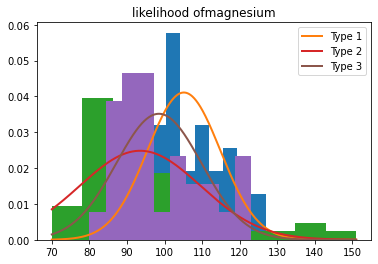

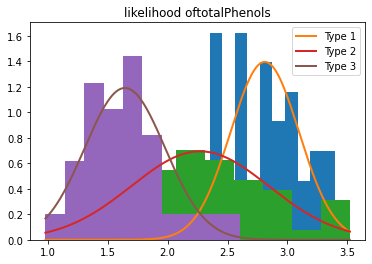

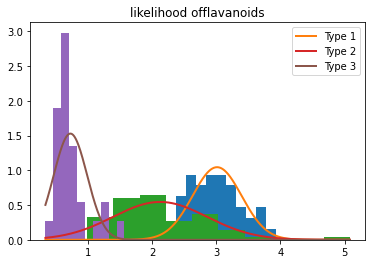

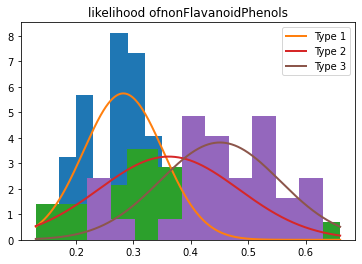

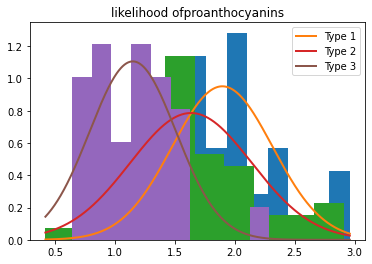

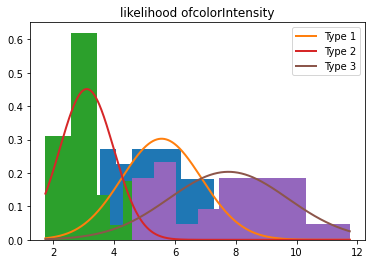

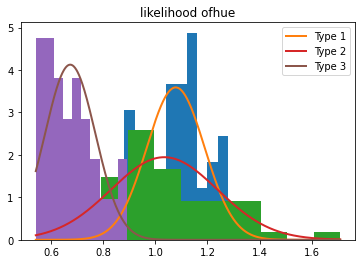

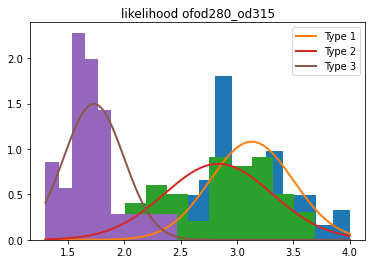

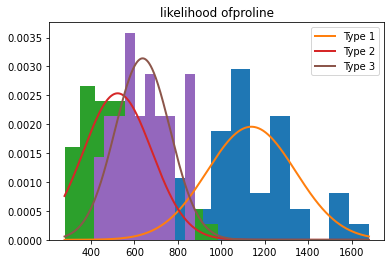

47 87.03703703703704


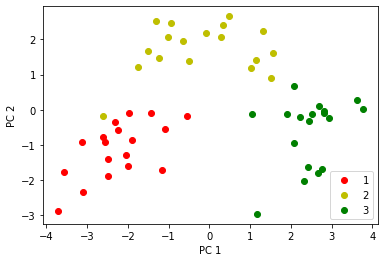

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import urllib3
from sklearn.utils import shuffle
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.stats import norm
from sklearn.decomposition import PCA



def find_nearindex(mean,std,b,x):
    array = norm.pdf(x, mean, std)
#    array = np.asarray(array)
    idx = (np.abs(x - b)).argmin()
    return array[idx]


get_ipython().run_line_magic('matplotlib', 'inline')

##Q1

header_name=[  'type'
              ,'alcohol'
              ,'malicAcid'
              ,'ash'
             ,'ashalcalinity'
              ,'magnesium'
             ,'totalPhenols'
              ,'flavanoids'
              ,'nonFlavanoidPhenols'
              ,'proanthocyanins'
             ,'colorIntensity'
              ,'hue'
              ,'od280_od315'
              ,'proline'
                ]

df=pd.read_csv('/Users/chiaentsai/Library/Containers/com.microsoft.Excel/Data/Desktop/wine.csv',header=None,names=header_name)
#df=pd.read_csv('Wine.csv',header=None,names=header_name)


# In[3]:
suffledata=shuffle(df)
test_data=suffledata.groupby(['type']).sample(n=18)
#print(test_data)
train_data_temp=df.drop(test_data.index)
train_data = train_data_temp.sort_values(by='type')
#print(train_data)



# In[4]:
test_data.to_csv('wine_test.csv',index=False,header=None)
train_data.to_csv('wine_train.csv',index=False,header=None)


# In[5]:
#train_data=shuffle(train_data)
X_train=train_data.drop('type',axis=1)
Y_train=train_data[['type']]
X_test=test_data.drop(['type'],axis=1)
Y_test=test_data[['type']]
##########################################################

# In[6]:

##Q2

#from sklearn.naive_bayes import GaussianNB
#model=GaussianNB()

# In[7]:
#model.fit(X_train,Y_train.values.flatten())
#print('The score of the model:',model.score(X_train,Y_train.values.flatten()))
#print('The score of the model:',model.score(X_test,Y_test.values.flatten()))


t=Y_train.value_counts().sort_index()
#print(t)

sp=np.zeros(4,dtype=int)
for i in range(0,3):
    sp[i+1]=sp[i]+t[i+1]
    
t=t.to_numpy()
prior=t/sum(t)
#plt.show();
mu=np.zeros((3,13))
omega=np.zeros((3,13))
for i in range(1,14):
    #Use Gaussian model to fit prior
    a=train_data[header_name[i]].to_numpy()
    #print(a)
    # plt.hist(a,density=True, alpha=0.6)
    # xmin, xmax = plt.xlim()

    x = np.linspace(min(a), max(a), 1001)
    #plt.plot(x, p, linewidth=2)

    for j in range(0,3):
        #Use Gaussian model to fit likelihood
        a=train_data[header_name[i]][sp[j]:sp[j+1]].to_numpy()
        mean,std = norm.fit(a)
        plt.hist(a,density="yes")
        xmin, xmax = plt.xlim()
        likelihood = norm.pdf(x, mean, std)
        mu[j][i-1]=mean
        omega[j][i-1]=std
        plt.plot(x, likelihood, label="Type %d"%(j+1), linewidth=2)
        plt.title("likelihood")
    plt.title("likelihood of"+header_name[i])
    plt.legend()
    plt.show()
    
b=X_test.to_numpy()
posterior=np.ones((3,54))
for i in range(13):
    x=np.linspace(min(b[i]),max(b[i]),1001)
    for j in range(54):
        for k in range(3):
            posterior[k][j]=posterior[k][j]*find_nearindex(mu[k][i],omega[k][i],b[j][i],x)

for i in range(3):
    posterior[i,:]= posterior[i,:]*prior[i]/124

result=np.zeros(54)
for i in range(54):
    result[i]=np.argmax(posterior[:,i])

correct=0
for i in range(54):
    if i<18 and (result[i] == 0):
        correct=correct+1 
    if (i>=18 and i<36) and (result[i] == 1):
        correct=correct+1    
    if (i>=36 and i<54) and (result[i] == 2):
        correct=correct+1

print(correct,np.float(correct*100/54))

#Q3

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.fit_transform(X_test)

cov_mat = np.cov(X_train_std.T)  #求共變異係數矩陣

eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)  #求共變異係數矩陣的特徵向量及特徵值

tot = sum(eigen_vals)  #計算解釋變異數比率 各特徵值/特徵值總和
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse = True)]
cum_var_exp = np.cumsum(var_exp)

import matplotlib.pyplot as plt

eigen_pairs =[(np.abs(eigen_vals[i]),eigen_vecs[:,i]) for i in range(len(eigen_vals))]
eigen_pairs.sort(reverse=True)

first = eigen_pairs[0][1]
second = eigen_pairs[1][1]
first = first[:,np.newaxis]
second = second[:,np.newaxis]
w = np.hstack((first,second))

#畫散點圖
X_test_pca = X_test_std.dot(w)
colors = ['r', 'y', 'g']
markers = ['o', 'o', 'o']
for l, c, m in zip(np.unique(Y_test), colors, markers):
    plt.scatter(X_test_pca[(Y_test.values==l).reshape(-1), 0], X_test_pca[(Y_test.values==l).reshape(-1), 1], c=c, label=l, marker=m) # 散點圖

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower right')
plt.show()